### Multilayer Perceptrons
Roger Wang
UCLA

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from torch.optim import SGD
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# MLP on FashionMNIST data

# dataset class to load FashionMNIST
class FashionMNIST():
    def __init__(self, root='../data', batch_size=64, resize=(28,28)):
        self.batch_size = batch_size
        self.resize = resize

        # image transforms, resize and convert to tensor
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])

        # initialize train (60k) and val (10k) sets
        self.train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(root=root,train=False,transform=trans,download=True)

    # data loader for dataset
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return DataLoader(data, self.batch_size, shuffle=train)
    
    # getting training data
    def train_dataloader(self):
        return self.get_dataloader(True)
    
    # getting val data
    def val_dataloader(self):
        return self.get_dataloader(False)

In [3]:
# MLP
class MLP(nn.Module):
    def __init__(self, inputs, hidden, outputs, lr, momentum=0, weight_decay=0):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.net = nn.Sequential(nn.Flatten(),
                                 nn.Linear(inputs,hidden),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(hidden,outputs),
                                 #nn.Dropout(0.5), dropout at output layer consistently increases val accuracy???
                                    # maybe makes model more robust to layer noise since some lables (pullover and coat) are ambigious
                                    # usually dropout avoided at output layer, this specific dataset may benefit from it
                                 )
        
    def forward(self, x):
        return self.net(x)
    
    # cross-entropy loss
    def loss(self, batch):
        logits, labels = batch
        return F.cross_entropy(logits, labels) # mean reduction default

    def accuracy(self, batch, averaged=True):
        logits, labels = batch
        logits, labels = logits.to('cpu'), labels.to('cpu')
        predict = self.predict(logits).type(labels.dtype)
        compare = (predict == labels).type(torch.float32) # bc predict now on cpu
        return compare.mean() if averaged else compare

    def predict(self, logits):
        return logits.argmax(axis=1) # issue w argmax on mps gpu

    def initOptimizer(self):
        self.optim = SGD(self.parameters(), self.lr, self.momentum, self.weight_decay)


In [4]:
# early stopping class
# criterion: validation accuracy
class EarlyStop():
    def __init__(self, patience, delta=0.003):
        self.patience = patience
        self.delta = delta
        self.best = 0
        self.count = 0

    def checkForStop(self, acc):
        if acc > self.best:
            self.best = acc
            self.count = 0
            return False
        elif acc < self.best-self.delta:
            if self.count > self.patience:
                return True
            self.count = self.count + 1
            return False

In [5]:
# training loop
def train(model, trainloader, valloader, epochs):
    train_loss = []
    val_loss = []
    val_acc = []
    model.initOptimizer()
    mps = torch.device('mps')
    model.to(mps)
    stopper = EarlyStop(3)

    pbar = tqdm(range(epochs))
    for i in range(epochs):
        train_loss.append(0)
        val_loss.append(0)
        val_acc.append(0)

        model.train()
        # training over batches of train set
        for n, (traindata,trainlabel) in enumerate(trainloader):
            traindata, trainlabel = traindata.to(mps), trainlabel.to(mps)
            model.optim.zero_grad()
            logits = model.forward(traindata)
            loss = model.loss((logits,trainlabel))
            loss.backward()
            model.optim.step()

            train_loss[i] = train_loss[i] + loss.item()
        train_loss[i] = train_loss[i] / len(trainloader)

        # validation over batches of val set
        model.eval()
        for n, (val,vallabel) in enumerate(valloader):
            val, vallabel = val.to(mps), vallabel.to(mps)
            with torch.no_grad():
                logits = model.forward(val)
                loss = model.loss((logits,vallabel))
                # accuracy needs to be computed on CPU???
                accuracy = model.accuracy((logits,vallabel))

                val_loss[i] = val_loss[i] + loss.item()
                val_acc[i] = val_acc[i] + accuracy
        val_loss[i] = val_loss[i] / len(valloader)
        val_acc[i] = val_acc[i] / len(valloader)

        # update pbar
        pbar.update(1)
        pbar.set_description(f'val_acc: {val_acc[i]:.3f} train_loss: {train_loss[i]:.3f}')

        # check for early stopping
        if stopper.checkForStop(val_acc[i]):
            break

    pbar.close()

    # display loss and acc
    #plt.plot(train_loss, label='train_loss')
    #plt.plot(val_loss, label='val_loss')
    plt.plot(val_acc)
    plt.xlabel('epoch')
    #plt.legend()

val_acc: 0.758 train_loss: 1.703: 100%|██████████| 200/200 [17:30<00:00,  5.25s/it]


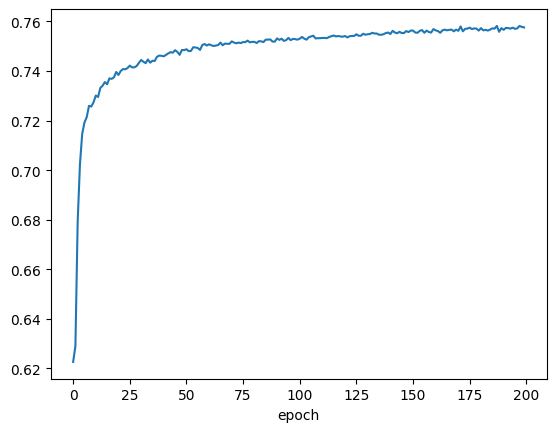

In [6]:
resize = (32,32)
inputs = resize[1]*resize[1]
hidden = 64

mps = torch.device('mps')
data = FashionMNIST(batch_size=128,resize=resize)
model = MLP(inputs,hidden,10,lr=0.03,momentum=0.7, weight_decay=0.3)
model.to(mps)

train(model,data.train_dataloader(),data.val_dataloader(),epochs=200)

*some takeaways when training model  
before adding dropout, val accuracy flutuates: this is a sign of overfitting  
model learns noise in training data and is sensitive -> fluctuating val accuracy
  
after adding dropout, better val accuracy, higher train loss

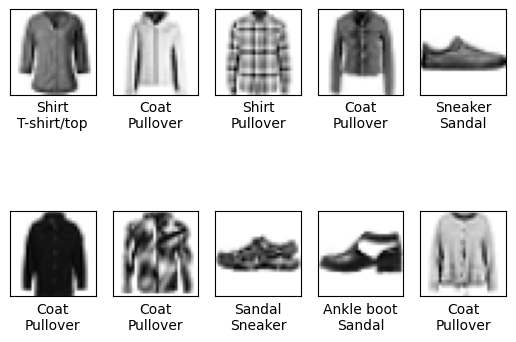

In [7]:
# where did model fail
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_2 = FashionMNIST(batch_size=1000,resize=(32,32))
valloader = data_2.val_dataloader()
valdata, vallabel = next(iter(valloader))

model.to('cpu')
model.eval()
logits = model.forward(valdata)
pred = model.predict(logits)

missed_idx = np.array((pred != vallabel).type(torch.float32))
missed_idx = np.where(missed_idx == 1)

missed = (valdata[missed_idx], vallabel[missed_idx], pred[missed_idx])

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(missed[0][i][0]), cmap=plt.cm.binary)
    plt.xlabel(labels[missed[1][i].item()] + '\n' + labels[missed[2][i]])

In [9]:
# classification metrics
def classification_metrics(true, pred, labels=None):
    # turn tensors to arrays, make sure same type
    true, pred = np.array(true).astype(int), np.array(pred).astype(int) 
    
    # create confusion matrix
    cm = confusion_matrix(true,pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(xticks_rotation='vertical')

    # TP,TN,FP,FN
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    # precision and recall by class
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)

    # macro averaged precision and recall
    N = len(precision)
    macro_precision = np.sum(precision) / N
    macro_recall = np.sum(recall) / N

    # micro averaged precision and recall
    micro_precision = np.sum(tp) / (np.sum(tp)+np.sum(fp))
    micro_recall = np.sum(tp) / (np.sum(tp)+np.sum(fn))

    # accuracy by class
    class_accuracy = (tp+tn) / (tp+fn+fp+tn)

    # overall accuracy
    accuracy = (true == pred).mean()

    # print metrics
    if labels is None:
        labels = np.unique(true)
    print(f' Class: \t\t Accuracy: \t\t Precision: \t\t Recall: \t\t')
    for i in range(N):
        print(f'  {labels[i]}: \t\t\t {class_accuracy[i]:.3f}\t\t\t {precision[i]:.3f}\t\t\t {recall[i]:.3f}')
    print(f'\n Overall Accuracy: \t{accuracy:.3f}')
    print(f' Macro Precision: \t{macro_precision:.3f} \t\t Micro Precision: \t{micro_precision:.3f}')
    print(f' Macro Recall: \t\t{macro_recall:.3f} \t\t Micro Recall: \t\t{micro_recall:.3f}')

 Class: 		 Accuracy: 		 Precision: 		 Recall: 		
  T-shirt/top: 			 0.952			 0.712			 0.925
  Trouser: 			 0.994			 0.981			 0.962
  Pullover: 			 0.837			 0.401			 0.946
  Dress: 			 0.956			 0.706			 0.903
  Coat: 			 0.885			 nan			 0.000
  Sandal: 			 0.993			 0.965			 0.954
  Shirt: 			 0.903			 nan			 0.000
  Sneaker: 			 0.988			 0.911			 0.968
  Bag: 			 0.993			 0.940			 0.989
  Ankle boot: 			 0.993			 0.989			 0.937

 Overall Accuracy: 	0.747
 Macro Precision: 	nan 		 Micro Precision: 	0.747
 Macro Recall: 		0.759 		 Micro Recall: 		0.747


/var/folders/rl/kfwnr9bn039czmp7dm8_ycmm0000gn/T/ipykernel_11575/15989414.py:18: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp+fp)


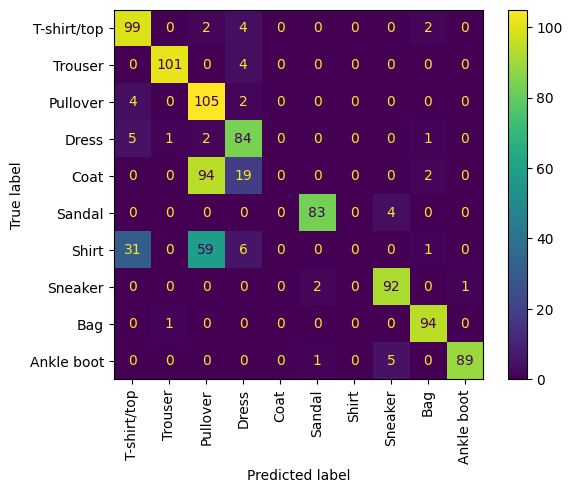

In [10]:
# display classification metrics
classification_metrics(vallabel,pred,labels=labels)
# notice how classes like pullover,coat, and shirt have low prediction scores
# consistent with analysis of dropout after output layer helping with label noise in these categories
# train model with dropout to show this


# want to see better scores on shirt precision and recall, which single neuron had 0.68 and 0.58
# MLP better at predicting shirt class
# MLP better accuracy and macro/micro scores across the board
# MLP more expressive

In [12]:
# MLP with dropout at output layer
class DropOutMLP(nn.Module):
    def __init__(self, inputs, hidden, outputs, lr, momentum=0, weight_decay=0):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

        self.net = nn.Sequential(nn.Flatten(),
                                 nn.Linear(inputs,hidden),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(hidden,outputs),
                                 nn.Dropout(0.5),
                                 nn.Softmax(dim=1))
        
    def forward(self, x):
        return self.net(x)
    
    # cross-entropy loss
    def loss(self, batch):
        logits, labels = batch
        return F.cross_entropy(logits, labels) # mean reduction default

    def accuracy(self, batch, averaged=True):
        logits, labels = batch
        logits, labels = logits.to('cpu'), labels.to('cpu')
        predict = self.predict(logits).type(labels.dtype)
        compare = (predict == labels).type(torch.float32) # bc predict now on cpu
        return compare.mean() if averaged else compare

    def predict(self, logits):
        return logits.argmax(axis=1) # issue w argmax on gpu

    def initOptimizer(self):
        self.optim = SGD(self.parameters(), self.lr, self.momentum, self.weight_decay)


val_acc: 0.860 train_loss: 1.915: 100%|██████████| 200/200 [17:52<00:00,  5.36s/it]


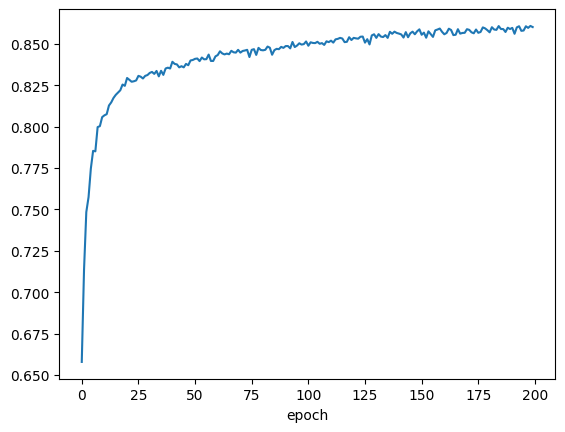

In [13]:
model2 = DropOutMLP(inputs,hidden,10,lr=0.03,momentum=0.7, weight_decay=0.3)
model2.to(mps)

train(model2,data.train_dataloader(),data.val_dataloader(),epochs=200)

 Class: 		 Accuracy: 		 Precision: 		 Recall: 		
  T-shirt/top: 			 0.972			 0.843			 0.907
  Trouser: 			 0.992			 0.962			 0.962
  Pullover: 			 0.954			 0.764			 0.847
  Dress: 			 0.971			 0.856			 0.828
  Coat: 			 0.962			 0.835			 0.835
  Sandal: 			 0.994			 0.976			 0.954
  Shirt: 			 0.939			 0.725			 0.598
  Sneaker: 			 0.986			 0.901			 0.958
  Bag: 			 0.993			 0.958			 0.968
  Ankle boot: 			 0.993			 0.989			 0.937

 Overall Accuracy: 	0.878
 Macro Precision: 	0.881 		 Micro Precision: 	0.878
 Macro Recall: 		0.879 		 Micro Recall: 		0.878


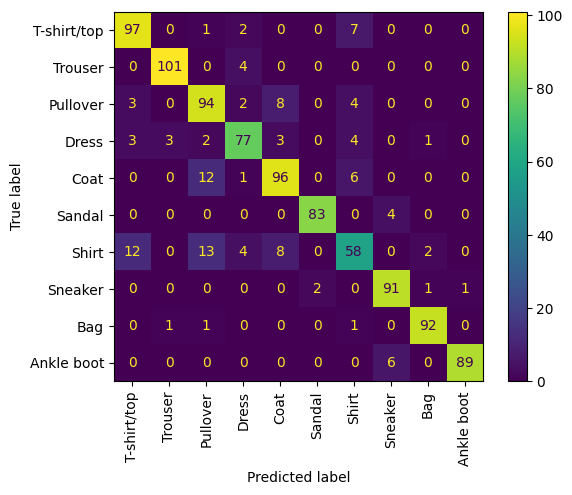

In [17]:
# visualize effect of dropout on making model robust to label noise
model2.to('cpu')
model2.eval()
logits = model2.forward(valdata)
pred = model2.predict(logits)

classification_metrics(vallabel,pred,labels=labels)

# notice how correct predictions of coat and shirt increase dramatically

# conclude that although dropout should not be used on output layer, in the case of datasets like FashionMNIST 
# that have considerable label ambiguity and noise, dropout in output layer can increase validation score and generalization ability